# Trajectory Clustering with cuSpatial

cuSpatial is a GPU-accelerated library for geospatial and spatiotemporal processing. It provides python bindings that rely on core datatypes (Series, Dataframes) from RAPIDS cuDF. cuSpatial provides significant GPU acceleration to common spatial and spatiotemporal operations such as point-in-polygon, distance between trajectories, and trajectory clustering. Speedups range from 10x to 10000x depending on the operation and comparison.

This notebook demonstrates accelerating a clustering problem using cuSpatial on a real-world vehicle trajectory dataset. On this particular use case, cuSpatial brings the end-to-end computation time from around 5 hours down to less than 15 seconds.

## Trajectory Clustering

Trajectory clustering groups a set of trajectories such that trajectories in the same group are more similar to each other than to those in other groups. It is useful for various problems such as motion pattern extraction, behavior analysis and more.

In general, clustering consists of two main components: a similarity metric and a search algorithm. Given a specific similarity metric, different clustering algorithms use different searching mechanisms and therefore have different complexity. In some cases it is desirable to precompute all pairwise similarities. One of the many reasons could be the need to perform multiple iterations of a hyperparameter search for the clustering algorithm to get a good result, and we don't want to redo the time-consuming similarity computation each time.

In this trajectory clustering example, we work on a particular vehicle trajectory dataset. Here are some summary statistics of the dataset.

| num_trajectories | 10070 |
|------------------|-------|
| max_length       | 961   |
| min_length       | 30    |
| avg_length       | 87    |

We use Hausdorff distance as the similarity metric between trajectories. We compute the pairwise similarity matrix and apply AgglomerativeClustering (AC) and DBSCAN afterwards.

In this example, cuSpatial can significantly accelerate the computation of the Hausdorff distance similarity matrix. Comparing to the typical scikit-learn implementation of Hausdorff distance (single CPU thread), cuSpatial reduces the computation time from about 5 hours to under 15 seconds on this particular dataset.

Since we pre-computed the similarity matrix, we can much more easily experiment with different clustering algorithm and different hyperparameter sets. In this example we do it in an interactive way using ipython widgets, you may play with the hyperparameter set and see how the clustering result responds.

## Install Dependencies
	
1. cuSpatial:    `conda install -c rapidsai-nightly cuspatial`
2. scikit-image: `pip install scikit-image` (conda install will delete pyarrow, be careful)
3. opencv: 	     `conda install -c conda-forge opencv`
4. ipywidgets: 	 `conda install -c anaconda ipywidgets`
5. scikit-learn: `conda install -c anaconda scikit-learn`

More [instructions on installing cuSpatial](https://github.com/rapidsai/cuspatial) (e.g. building from source).

In [1]:
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from ipywidgets import interact, interactive, fixed
from ipywidgets import *
import time

from scipy.spatial.distance import directed_hausdorff
from sklearn.cluster import AgglomerativeClustering,KMeans,DBSCAN

import cudf
import cuspatial
from matplotlib import gridspec

## Load and prepare the data

### Load preprocessed trajectories

In [2]:
import pickle

with open('data/trajectories_extracted.p','rb') as f:
    trajectories = pickle.load(f)

### Define trajectory transform functions

In [3]:
def convert_latlon_2_image_for_vis_wrongway_intersection(lat,long):

    x_anchor = 436.369
    y_anchor = 126.613
    long_anchor = -90.666714
    lat_anchor = 42.492466

    long_1 = -90.663183
    lat_1 = 42.491671
    x_1 = 971.026
    y_1 = 291.955

    long_2_x_rate = (x_1-x_anchor)/(long_1-long_anchor)
    lat_2_y_rate = (y_1-y_anchor)/(lat_1-lat_anchor)

    y = (lat-lat_anchor)*lat_2_y_rate+y_anchor
    x = (long-long_anchor)*long_2_x_rate+x_anchor

    return x, y

def convert_traj_latlon_2_image_wrongway_intersection(traj):

    traj_image = []
    for pt in traj:
        lat = pt[0]
        long = pt[1]
        x,y = convert_latlon_2_image_for_vis_wrongway_intersection(lat,long)
        traj_image.append((x,y))

    return np.asarray(traj_image)

def traj_filter_num_points(trajectories,num_min):
    max_length = 0
    min_length = 999
    lengths = []
    long_trajectories = []
    for traj in trajectories:
        if len(traj)>=num_min:
            long_trajectories.append(traj)
            if len(traj)<min_length:
                min_length = len(traj)
            lengths.append(len(traj))
        if len(traj) > max_length:
            max_length = len(traj)
    print("the longest traj length is: ",max_length)
    print("the shortest traj length is: ",min_length)
    print("the average traj length is: ",int(np.mean(lengths)))
    return long_trajectories

def pick_traj_with_label(label,labels,trajectories):
    selected_trajectories = []
    for i in range(len(labels)):
        if labels[i] == label:
            selected_trajectories.append(trajectories[i])
    return selected_trajectories  

### Filter and transform trajectories

In [4]:
print('Filtering based on number of points ...')
trajectories = traj_filter_num_points(trajectories,num_min=30)
print('{} left after filtering based on number of points'.format(len(trajectories)))

trajectories = [convert_traj_latlon_2_image_wrongway_intersection(trajectory) for trajectory in trajectories]

Filtering based on number of points ...
the longest traj length is:  961
the shortest traj length is:  30
the average traj length is:  87
10070 left after filtering based on number of points


### Visualize the filtered trajectories

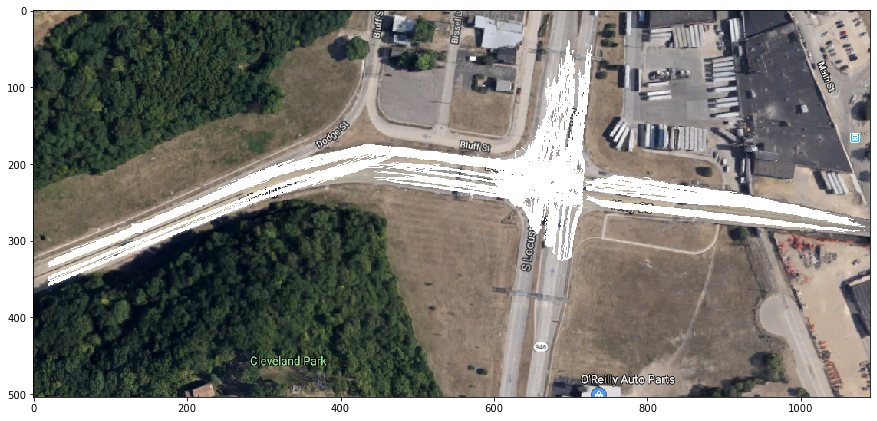

In [5]:
MAP_FILE = 'data/target_intersection.png'
bg_image = io.imread(MAP_FILE)
scale = (42.489814152793585,-90.67464958318888,42.492905837844546,-90.66237875113197)
img = np.copy(bg_image)
for trajectory in trajectories:
    
    cv2.polylines(img,np.int32([np.array(trajectory).reshape(-1,1,2)]),False, (255,255,255), 1)

plt.figure(figsize=(15,15))
plt.imshow(img)

## Clustering Similarity Metric: Hausdorff distance

Calculate `Hausdorff distance` matrix using scipy library (single thread CPU)

### It took >19000 seconds (~5.3 hours) to finish

In [ ]:
import math
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
dmatrix=np.zeros((len(trajectories),len(trajectories)))
count = 0
total = len(trajectories)*len(trajectories)
for i in range(dmatrix.shape[0]):
    for j in range(dmatrix.shape[1]):
        count += 1
        dmatrix[i][j] = directed_hausdorff(trajectories[i],trajectories[j])[0]
        if (count % (int(total*0.01))) == 0:
            print('finished: {0:d}/{1:d} {2:.0f}% {3}'.format(count,total,count//(total*0.01) * 1,timeSince(start)))
end = time.time()
print('duration:',end-start)

## Accelerating the Similarity metric with cuSpatial 

Calculate `Hausdorff distance` matrix using the cuSpatial library (GPU). Keep an eye on the speed! :)

In [7]:
start = time.time()
cnt = []
for traj in trajectories:
    cnt.append(len(traj))
cnt = np.asarray(cnt)

trajs = np.concatenate([np.asarray(traj) for traj in trajectories],0)

x_s = trajs[:,0]
y_s = trajs[:,1]

pnt_x=cudf.Series(x_s)
pnt_y=cudf.Series(y_s)
cnt=cudf.Series(cnt)

start1 = time.time()
dist=cuspatial.directed_hausdorff_distance(pnt_x,pnt_y,cnt)
end1 = time.time() 
print('\nHausdroff distance calculation by Cuspatial in GPU takes: \n  {0:.3f} seconds (~1500X)'.format(end1 - start1))
urt=dist.data.to_array()
dmatrix = np.reshape(urt,(len(cnt),len(cnt)))
end = time.time()
print('\nThe complete Dmatrix calculation including data transitioning and transforming takes: \n  {0:.3f} seconds (~1400X)'.format(end - start)) 


Hausdroff distance calculation by Cuspatial in GPU takes: 
  12.599 seconds (~1500X)

The complete Dmatrix calculation including data transitioning and transforming takes: 
  13.725 seconds (~1400X)


In [8]:
start = time.time()
agg = AgglomerativeClustering(n_clusters=10, affinity='precomputed', linkage = 'average')
agg_result = agg.fit(dmatrix)
end = time.time()
print('A complete AC search takes:\n  {0:.3f} seconds'.format(end - start)) 

A complete AC search takes:
  3.944 seconds


In [9]:
start = time.time()
dbscan = DBSCAN(eps=20, metric='precomputed',min_samples=2)
dbscan_result = dbscan.fit(dmatrix)
end = time.time()
print('A complete DBSCAN search takes:\n  {0:.3f} seconds'.format(end - start)) 

A complete DBSCAN search takes:
  1.273 seconds


## Visualize AgglomerativeClustering results

All clusters overlaid, interactive mode.

In [10]:
def visualize_gt_vs_pred(n_clusters,linkage):
    print('AgglomerativeClustering')
    agg = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage = linkage)
    agg_result = agg.fit(dmatrix)
    
    labels = agg_result.labels_

    print('#clusters = ',np.max(labels)+1)
    img = np.copy(bg_image)
    for label in range(np.max(labels)+1):

        color = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
        selected_trajectories = pick_traj_with_label(label,labels,trajectories)


        for trajectory in selected_trajectories:
            cv2.polylines(img,np.int32([np.array(trajectory).reshape(-1,1,2)]),False, color, 2)
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    
    
    
interact(visualize_gt_vs_pred,
         n_clusters=widgets.IntText(value=12,description='n_clusters:',disabled=False),
         
         linkage=widgets.ToggleButtons(
                value='average',
                options=['complete', 'average', 'single'],
                description='linkage:',
                disabled=False,
                button_style='', # 'success', 'info', 'warning', 'danger' or ''
            )
        )

interactive(children=(IntText(value=12, description='n_clusters:'), ToggleButtons(description='linkage:', inde…

<function __main__.visualize_gt_vs_pred(n_clusters, linkage)>

## Visualize DBSCAN results
All clusters overlaid, interactive mode.

In [11]:
def visualize_gt_vs_pred(eps,min_samples):
    print('DBSCAN')
    dbscan = DBSCAN(eps=eps, metric='precomputed',min_samples=min_samples)
    dbscan_result = dbscan.fit(dmatrix)
    
    labels = dbscan.labels_

    print('#clusters = ',np.max(labels)+1)
    img = np.copy(bg_image)
    for label in range(np.max(labels)+1):

        color = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
        selected_trajectories = pick_traj_with_label(label,labels,trajectories)


        for trajectory in selected_trajectories:
            cv2.polylines(img,np.int32([np.array(trajectory).reshape(-1,1,2)]),False, color, 2)
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    
interact(visualize_gt_vs_pred,
         min_samples=widgets.IntText(value=600,description='min_samples:',disabled=False),
         
         eps=widgets.ToggleButtons(
                value=20,
                options=[5,10,11,12,13,14,15,20,23,27,30],
                description='eps:',
                disabled=False,
                button_style='', # 'success', 'info', 'warning', 'danger' or ''
            )
        )

interactive(children=(ToggleButtons(description='eps:', index=7, options=(5, 10, 11, 12, 13, 14, 15, 20, 23, 2…

<function __main__.visualize_gt_vs_pred(eps, min_samples)>

## Visualize AgglomerativeClustering results
Clusters in separate subplots, interactive mode.

In [12]:

def visualize_gt_vs_pred(n_clusters,linkage):
    print('AgglomerativeClustering')
    agg = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage = linkage)
    agg_result = agg.fit(dmatrix)
    
    labels = agg_result.labels_

    print('#clusters = ',np.max(labels)+1)
    
    
    plt.figure(figsize=(15,15))
    gs = gridspec.GridSpec(5, int(np.ceil(n_clusters/5)) , wspace=0, hspace=0)
    idx = 0
    for label in range(np.max(labels)+1):
        
        ax = plt.subplot(gs[idx])
        idx+=1
        img = np.copy(bg_image)
#         color = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
        color = (0,255,0)
        selected_trajectories = pick_traj_with_label(label,labels,trajectories)


        for trajectory in selected_trajectories:
            cv2.polylines(img,np.int32([np.array(trajectory).reshape(-1,1,2)]),False, color, 2)
    
        plt.imshow(img)
    
interact(visualize_gt_vs_pred,
         n_clusters=widgets.IntText(value=12,description='n_clusters:',disabled=False),
         
         linkage=widgets.ToggleButtons(
                value = 'average',
                options=['complete', 'average', 'single'],
                description='linkage:',
                disabled=False,
                button_style='', # 'success', 'info', 'warning', 'danger' or ''
            )
        )

interactive(children=(IntText(value=12, description='n_clusters:'), ToggleButtons(description='linkage:', inde…

<function __main__.visualize_gt_vs_pred(n_clusters, linkage)>

## Visualize DBSCAN results
Clusters in separate subplots, interactive mode.

In [13]:

def visualize_gt_vs_pred(eps,min_samples):
    print('DBSCAN')
    dbscan = DBSCAN(eps=eps, metric='precomputed',min_samples=min_samples)
    dbscan_result = dbscan.fit(dmatrix)
    
    labels = dbscan_result.labels_

    print('#clusters = ',np.max(labels)+1)
    
    
    plt.figure(figsize=(15,15))
    gs = gridspec.GridSpec(5, int(np.ceil((np.max(labels)+1)/5)) , wspace=0, hspace=0)
    idx = 0
    for label in range(np.max(labels)+1):
        
        ax = plt.subplot(gs[idx])
        idx+=1
        img = np.copy(bg_image)
#         color = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
        color = (0,255,0)
        selected_trajectories = pick_traj_with_label(label,labels,trajectories)


        for trajectory in selected_trajectories:
            cv2.polylines(img,np.int32([np.array(trajectory).reshape(-1,1,2)]),False, color, 2)
    
        plt.imshow(img)
    
interact(visualize_gt_vs_pred,
         min_samples=widgets.IntText(value=600,description='min_samples:',disabled=False),
         
         eps=widgets.ToggleButtons(
                value=20,
                options=[5,10,12,13,14,15,20,25,30],
#                 options=[5,10,11,12,13,14,15,20,30],
                description='eps:',
                disabled=False,
                button_style='', # 'success', 'info', 'warning', 'danger' or ''
            )
        )

interactive(children=(ToggleButtons(description='eps:', index=6, options=(5, 10, 12, 13, 14, 15, 20, 25, 30), …

<function __main__.visualize_gt_vs_pred(eps, min_samples)>